In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [45]:
data = pd.read_csv('https://raw.githubusercontent.com/bdemeshev/psmo_2022-23/main/ha_02/psmo-ha_02.csv')
data

,y,x
0,9.045355,11.959145
1,19.449570,8.405834
2,8.511532,12.043345
3,11.957874,8.404752
4,-7.660798,16.554744
...,...,...
195,16.549112,5.671288
196,15.237357,9.323229
197,15.858755,8.491993
198,17.135944,6.906642


In [2]:
data = pd.read_csv('/content/dataSetFull.csv')
data = data[['price_eur', 'Area', 'room']]\
        .dropna()\
        .sample(n=500, random_state=1)\
        .reset_index(drop=True)
data

,price_eur,Area,room
0,57350.0,40.0,1.0
1,133300.0,166.0,3.0
2,117800.0,205.0,4.0
3,201500.0,293.0,3.0
4,184450.0,200.0,3.0
...,...,...,...
495,279000.0,491.0,4.0
496,111600.0,154.0,3.0
497,162750.0,200.0,1.0
498,86180.0,103.0,2.0


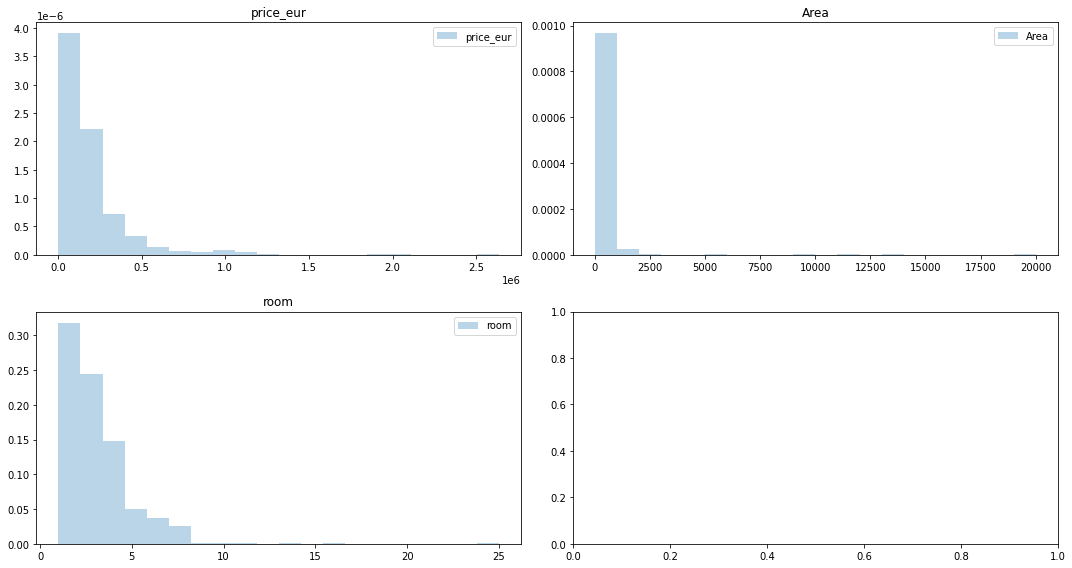

In [3]:
def plot_hists(X: pd.DataFrame, plot_cols = 2, bins=np.linspace(-3, 3, 61)):
    fig, axs = plt.subplots(len(X.columns)//plot_cols+1, 2, figsize=(15, 8))
    for i, column in enumerate(X.columns):
        axs[i//plot_cols, i%plot_cols].hist(X[column], bins=20, alpha=0.3, label=X.columns[i], color='C0', density=True)
        axs[i//plot_cols, i%plot_cols].set_title(column)
        axs[i//plot_cols, i%plot_cols].legend(loc='best')
    plt.tight_layout()
plot_hists(data)

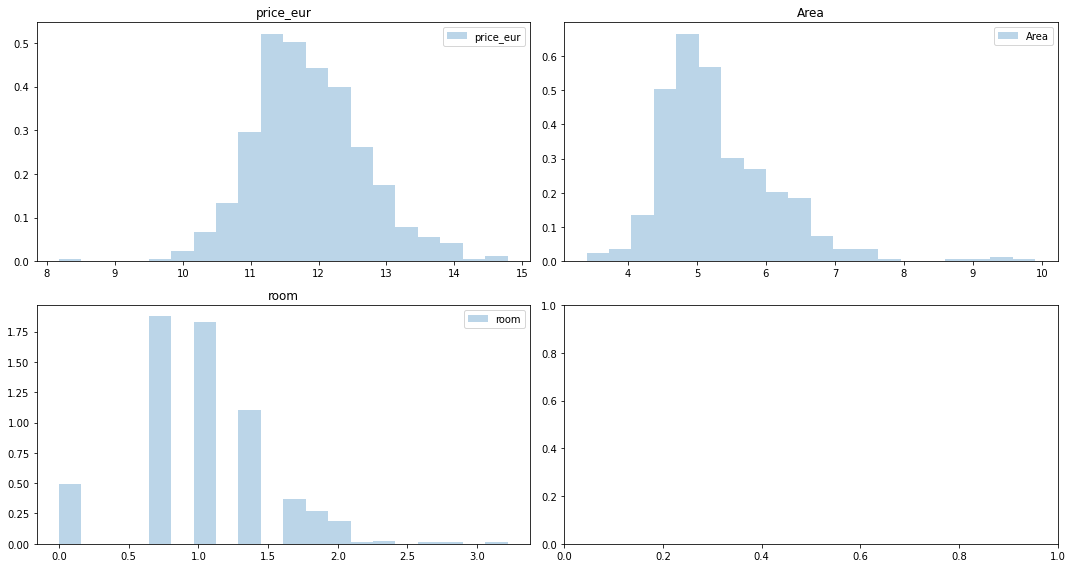

In [4]:
data_log = data.copy()
for col in data.columns:
  data_log[col] = np.log(data[col])
plot_hists(data_log)

# Рассмотрим модель линейной регрессии 

$ \hat y_i = \hat \beta_1 + \hat\beta_2 x_i + \hat\beta_3 x_i^2. $

$ \hat \log{price_i} = \hat \beta_1 + \hat\beta_2 \log{area_i} + \hat\beta_3 \log{rooms_i}. $
* С помощью наивного бутстрэпа постройте 95\%-й доверительный интервал для каждого коэффициента.
* С помощью наивного бутстрэпа постройте 95\%-й доверительный интервал для вершины параболы. 


Наивный бутстрэп - это когда мы делаем выборку с возвращением размерности такой же, как исходная выборка

Де-факто от нас требуется построить n_iter регрессий по n_iter выборкам (каждой регрессии соответствует одна выборка) и взять квантили 0.025 и 0.975 от получившихся точечных оценок коэффициентов

In [5]:
import statsmodels.formula.api as smf # Модели
import statsmodels.stats.api as sms # Тесты
import statsmodels.api as sm

Посмотрим на 95%-ые доверительные интервалы без бутстрэпа:

In [6]:
data_c = sm.add_constant(data_log)
model = sm.OLS(endog = data_c['price_eur'],
               exog = data_c.drop(columns='price_eur')).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_eur   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     294.1
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           5.14e-85
Time:                        15:43:07   Log-Likelihood:                -411.05
No. Observations:                 500   AIC:                             828.1
Df Residuals:                     497   BIC:                             840.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4976      0.164     51.717      0.000       8.175       8.820
Area           0.5673      0.037     15.439      0.000       0.495       0.640
room           0.3236      0.063      5.109      0.000       0.199       0.448
==============================================================================
Omnibus:                       69.048   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.339
Skew:                          -0.610   Prob(JB):                     9.61e-51
Kurtosis:                       6.093   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
data_c

,const,price_eur,Area,room
0,1.0,10.956928,3.688879,0.000000
1,1.0,11.800358,5.111988,1.098612
2,1.0,11.676744,5.323010,1.386294
3,1.0,12.213545,5.680173,1.098612
4,1.0,12.125134,5.298317,1.098612
...,...,...,...,...
495,1.0,12.538967,6.196444,1.386294
496,1.0,11.622676,5.036953,1.098612
497,1.0,11.999971,5.298317,0.000000
498,1.0,11.364193,4.634729,0.693147


Проверим, что функционал Pandas даёт разные выборки при разных random_state, одинаковые при одинаковых

In [13]:
data_c.sample(n=500, random_state=1, replace=True).reset_index()['index'].value_counts()

490    4
43     4
279    4
338    4
489    4
      ..
319    1
199    1
7      1
420    1
93     1
Name: index, Length: 322, dtype: int64

In [55]:
display(data_c.sample(n=3, random_state=1, replace=True))
display(data_c.sample(n=3, random_state=1, replace=True))
display(data_c.sample(n=3, random_state=2, replace=True))

,const,price_eur,Area,room
37,1.0,10.290449,4.615121,1.098612
235,1.0,11.299175,5.313206,0.693147
396,1.0,10.842518,4.382027,0.693147


,const,price_eur,Area,room
37,1.0,10.290449,4.615121,1.098612
235,1.0,11.299175,5.313206,0.693147
396,1.0,10.842518,4.382027,0.693147


,const,price_eur,Area,room
168,1.0,11.463420,4.204693,0.000000
15,1.0,11.334994,4.727388,0.693147
493,1.0,11.580117,4.905275,1.098612


Напишем функцию для сэмплирования регрессий:

In [14]:
def sample_reg(df:pd.DataFrame, # датасет, по которому будем решать задачу
               target:str='price_eur', # целевая переменная
               n_iter:int=20, # количество бутстрап-итераций
               size:int=200, # размер выборки
               ci:float=0.95, # величина доверительного интервала
               need_coefs:bool=False):
  coefs = {key: [] for key in list(df.drop(columns=target).columns)} # где-то надо хранить коэффициенты
  for i in tqdm(range(n_iter)):
    df_temp = df.sample(n=size, random_state=i, replace=True) # сэмплируем элементы выборки с возвращением и фиксацией random_seed
    model = sm.OLS(endog = df_temp[target],
                   exog = df_temp.drop(columns=target)).fit() # обучаем линейную модель
    for col in model.params.index:
      coefs[col].append(model.params[col]) # заполняем словарик точечными оценками коэффициентов
  
  coefs = pd.DataFrame(coefs)
  for col in model.params.index:
    print(str(int(ci*100))+'%-ый доверительный интервал для коэффициента '+col+' равен:')
    print('[', '{:.4f}'.format(coefs[col].quantile(q=(1-ci)/2)), ';', # просто берём квантиль 0.025
          '{:.4f}'.format(coefs[col].quantile(q=1-(1-ci)/2)), ']') # просто берём квантиль 0.975

  ###
  # Здесь нужно написать код для бутстрапирования вершины параболы в ДЗ-2
  ###
  if need_coefs:
    return coefs

Проверим, что результаты сходятся при разных запусках и дают возможность сделать одинаковые выводы, даже если перезапустить тетрадку с нуля:

In [15]:
sample_reg(data_c, n_iter=100, size=len(data_c))

100%|██████████| 100/100 [00:00<00:00, 429.37it/s]

95%-ый доверительный интервал для коэффициента const равен:
[ 7.9198 ; 8.9292 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.4590 ; 0.7059 ]
95%-ый доверительный интервал для коэффициента room равен:
[ 0.1697 ; 0.4939 ]


In [16]:
sample_reg(data_c, n_iter=100, size=len(data_c))

100%|██████████| 100/100 [00:00<00:00, 418.87it/s]

95%-ый доверительный интервал для коэффициента const равен:
[ 7.9198 ; 8.9292 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.4590 ; 0.7059 ]
95%-ый доверительный интервал для коэффициента room равен:
[ 0.1697 ; 0.4939 ]


Ответим на вопрос задачи:

In [17]:
sample_reg(data_c, n_iter=10**4, size=len(data_c))

100%|██████████| 10000/10000 [00:24<00:00, 402.88it/s]

95%-ый доверительный интервал для коэффициента const равен:
[ 7.8751 ; 8.9862 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.4522 ; 0.7135 ]
95%-ый доверительный интервал для коэффициента room равен:
[ 0.1562 ; 0.4826 ]


In [18]:
coefs = sample_reg(data_c, n_iter=10**4, size=len(data_c), need_coefs=True)
coefs = pd.DataFrame(coefs)
coefs.describe(percentiles=[0.025, 0.5, 0.975])

100%|██████████| 10000/10000 [00:24<00:00, 403.83it/s]

95%-ый доверительный интервал для коэффициента const равен:
[ 7.8751 ; 8.9862 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.4522 ; 0.7135 ]
95%-ый доверительный интервал для коэффициента room равен:
[ 0.1562 ; 0.4826 ]


,const,Area,room
count,10000.000000,10000.000000,10000.000000
mean,8.469319,0.573588,0.319772
std,0.285327,0.067358,0.082525
min,7.290797,0.320253,0.023361
2.5%,7.875083,0.452190,0.156235
50%,8.485476,0.569717,0.320050
97.5%,8.986158,0.713532,0.482588
max,9.592115,0.866012,0.661088


# Рассмотрим модель [квантильной регрессии](https://en.wikipedia.org/wiki/Quantile_regression) для квантилей $\tau=0.25$, $\tau=0.5$, $\tau=0.75$:

Квантильная регрессия - Целевая функция $\sum_{i=1}^n \rho_{\tau}(y_i - \hat y_i)$, где $\rho_{\tau}(u) = u\cdot (\tau - I(u<0))$

$\hat y_i = \hat \beta_1 + \hat\beta_2 x_i + \hat\beta_3 x_i^2$
* Постройте три полученные линии регрессии на одном графике с данными. 
* Для медианной регрессии с помощью наивного бутстрэпа постройте 95\%-й доверительный интервал для каждого коэффициента.
* Для медианной регрессии с помощью наивного бутстрэпа постройте 95\%-й доверительный интервал для вершины параболы. 


## Преимущества квантильной регрессии

* "quantile regression estimates are more robust against outliers in the response measurements" - более стабильна при выбросах в значениях целевой переменной
* более широкий анализ взаимосвязей объясняющих переменных с целевой (целевая переменная может иметь разные паттерны в зависимости от какого-то условия и в таких случаях будет уместно применять квантильную регрессию)

Интуиция для данной задачи:
* большая часть домов предназначены для среднего класса, для них уместно применять медианную регрессию, но есть очень маленькие квартиры для очень бедных людей и очень большие дома для олигархов (нужны регрессии на квантили 0.05 и 0.99)

[Маленькое видео от Бориса Борисовича по квантильной регрессии](https://youtu.be/J2TfsGQ57B4)

In [19]:
from statsmodels.regression.quantile_regression import QuantReg

In [20]:
quantiles = [0.05, 0.5, 0.99]
data_viz = data[['price_eur', 'Area']]
for q in quantiles:
  model = QuantReg(endog = data_c['price_eur'],
               exog = data_c.drop(columns='price_eur')).fit(q=q)
  data_viz['y_'+str(q)] = np.exp(model.predict(data_c.drop(columns='price_eur')))
data_viz

,price_eur,Area,y_0.05,y_0.5,y_0.99
0,57350.0,40.0,18757.342275,39646.724319,6.989411e+04
1,133300.0,166.0,52290.488028,128023.520314,4.031013e+05
2,117800.0,205.0,63657.277047,156022.663637,5.539746e+05
3,201500.0,293.0,67295.678870,187910.212604,6.614910e+05
4,184450.0,200.0,56800.621577,145192.495297,4.741949e+05
...,...,...,...,...,...
495,279000.0,491.0,93815.484023,281439.070335,1.186217e+06
496,111600.0,154.0,50577.047674,121697.136289,3.775779e+05
497,162750.0,200.0,38328.620996,117568.092792,2.842886e+05
498,86180.0,103.0,36588.404344,85797.107919,2.201516e+05


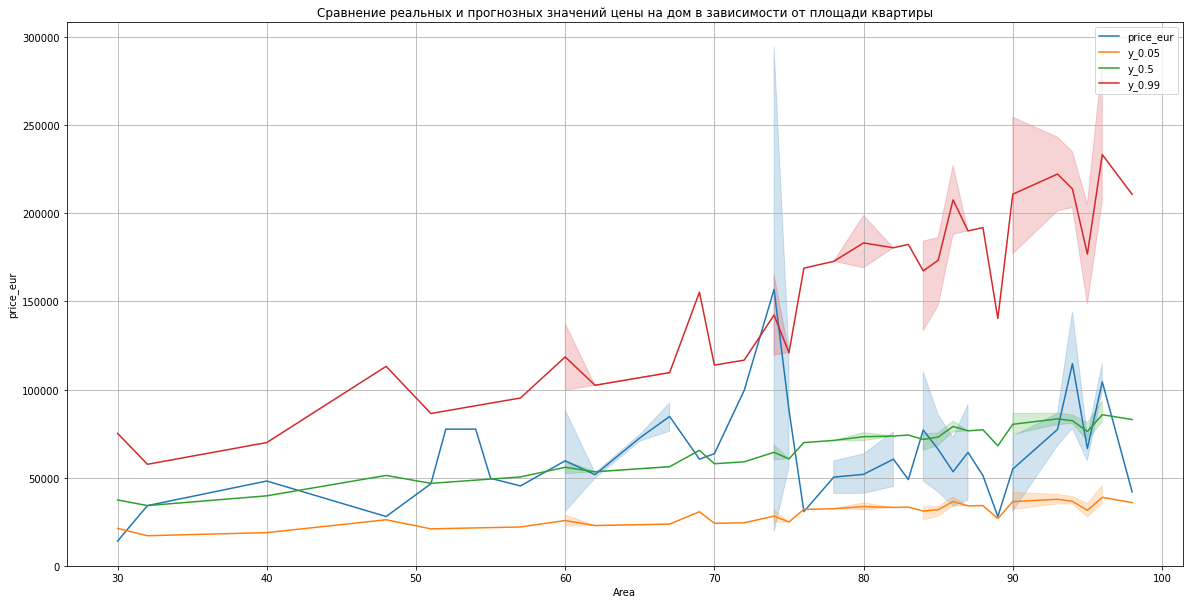

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.grid()
ax.set_title('Сравнение реальных и прогнозных значений цены на дом в зависимости от площади квартиры')
for col in data_viz.drop(columns='Area'):
  sns.lineplot(data=data_viz.loc[data_viz['Area']<100], x='Area', y=col, ax=ax, label=col)

In [24]:
def sample_q_reg(df:pd.DataFrame, # датасет, по которому будем решать задачу
               target:str='price_eur', # целевая переменная
               n_iter:int=20, # количество бутстрап-итераций
               size:int=200, # размер выборки
               ci:float=0.95, # величина доверительного интервала
               quantiles:list=[0.05, 0.5, 0.99],
               max_iter:int=10**4,
               need_coefs:bool=False):
  for q in quantiles: # к коду из предыдущей задачи накидываем цикл на квантили
    print('Квантильная регрессия с q='+str(q))
    coefs = {key: [] for key in list(df.drop(columns=target).columns)} # где-то надо хранить коэффициенты
    for i in tqdm(range(n_iter)):
      df_temp = df.sample(n=size, random_state=i, replace=True) # сэмплируем элементы выборки с возвращением и фиксацией random_seed
      model = QuantReg(endog = df_temp[target],
                    exog = df_temp.drop(columns=target)).fit(q=q, max_iter=max_iter) # обучаем линейную модель
                                                        # обратим внимание, что здесь в fit отправляются тербуемые квантили и max_iter
      for col in model.params.index:
        coefs[col].append(model.params[col]) # заполняем словарик
    
    coefs = pd.DataFrame(coefs)
    for col in model.params.index:
      print(str(int(ci*100))+'%-ый доверительный интервал для коэффициента '+col+' равен:')
      print('[', '{:.4f}'.format(coefs[col].quantile(q=(1-ci)/2)), ';', # просто берём квантиль 0.025
            '{:.4f}'.format(coefs[col].quantile(q=1-(1-ci)/2)), ']') # просто берём квантиль 0.975
    print()
  ###
  # Здесь нужно написать код для бутстрапирования вершины параболы в ДЗ-2
  ###
  if need_coefs: # для этой задачи этот момент надо доработать, ибо оценивается несколько регрессий
    return coefs

In [25]:
sample_q_reg(data_c, n_iter=100, size=len(data_c), max_iter=10**3)

Квантильная регрессия с q=0.05


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
100%|██████████| 100/100 [00:02<00:00, 45.74it/s]


95%-ый доверительный интервал для коэффициента const равен:
[ 7.5067 ; 9.0071 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.2776 ; 0.6064 ]
95%-ый доверительный интервал для коэффициента room равен:
[ 0.0893 ; 0.6091 ]

Квантильная регрессия с q=0.5


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 47%|████▋     | 47/100 [00:01<00:01, 44.33it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 59%|█████▉    | 59/100 [00:01<00:00, 42.04it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 82%|████████▏ | 82/100 [00:02<00:00, 43.24it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
100%|██████████| 100/100 [00:

95%-ый доверительный интервал для коэффициента const равен:
[ 7.4260 ; 8.5365 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.5516 ; 0.8449 ]
95%-ый доверительный интервал для коэффициента room равен:
[ -0.0282 ; 0.4066 ]

Квантильная регрессия с q=0.99


 18%|█▊        | 18/100 [00:00<00:01, 54.25it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
100%|██████████| 100/100 [00:01<00:00, 55.52it/s]


95%-ый доверительный интервал для коэффициента const равен:
[ 6.2199 ; 10.1763 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.4455 ; 1.2789 ]
95%-ый доверительный интервал для коэффициента room равен:
[ -0.7435 ; 0.8672 ]



Так, как выше - не надо! Логи с ошибкой в тетрадке на проверку не хочет видеть ни преподаватель, ни руководитель на работе

Либо отключаем warning'и через специальную либу, либо увеличиваем количество итераций для одной бутстрап-выборки, пока они не будут вылетать на регулярной основе

In [26]:
sample_q_reg(data_c, n_iter=100, size=len(data_c), max_iter=10**6)

Квантильная регрессия с q=0.05


100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


95%-ый доверительный интервал для коэффициента const равен:
[ 7.5067 ; 9.0172 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.2754 ; 0.6064 ]
95%-ый доверительный интервал для коэффициента room равен:
[ 0.0893 ; 0.6091 ]

Квантильная регрессия с q=0.5


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


95%-ый доверительный интервал для коэффициента const равен:
[ 7.4260 ; 8.5365 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.5516 ; 0.8449 ]
95%-ый доверительный интервал для коэффициента room равен:
[ -0.0282 ; 0.4066 ]

Квантильная регрессия с q=0.99


100%|██████████| 100/100 [00:01<00:00, 50.02it/s]

95%-ый доверительный интервал для коэффициента const равен:
[ 6.2199 ; 10.1763 ]
95%-ый доверительный интервал для коэффициента Area равен:
[ 0.4455 ; 1.2789 ]
95%-ый доверительный интервал для коэффициента room равен:
[ -0.7435 ; 0.8672 ]



# Хинт по №4

в t-бутстрэпе в качестве $\hat{se}$ берётся наблюдаемое стандартное отклонение оцениваемого параметра по исходной выборке. Для случая медианы в качестве таковой можно взять [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation)